In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib as plt

# Downloading and checking the data

In [2]:
persons = dd.read_csv(r'T:\socioec\Current_Projects\SR15\S0\version6\abm_csv\synthetic_persons_2022_01.csv',
                      dtype={'NAICS2': 'object'},
                      blocksize=25e6)
print((persons.shape[0].compute(), persons.shape[1]))
persons.head()

(3282455, 17)


,mgra,household_id,SPORDER,AGEP,SEX,ESR,COW,WKHP,SCHG,RAC1P,HISP,MIL,SCHL,OCCP,WKW,NAICS2,SOC2
0,57,1,1,34,2,1.0,1.0,40.0,0,1,2,4.0,17.0,4850.0,1.0,33,41
1,57,1,2,16,2,6.0,0.0,0.0,13,1,2,0.0,13.0,0.0,0.0,0,0
2,57,1,3,15,2,0.0,0.0,0.0,11,1,2,0.0,11.0,0.0,0.0,0,0
3,57,1,4,14,2,0.0,0.0,0.0,11,1,2,0.0,11.0,0.0,0.0,0,0
4,57,1,5,12,1,0.0,0.0,0.0,8,1,2,0.0,8.0,0.0,0.0,0,0


In [3]:
households = dd.read_csv(r'T:\socioec\Current_Projects\SR15\S0\version6\abm_csv\synthetic_households_2022_01.csv',
                      blocksize=25e6)
print((households.shape[0].compute(), households.shape[1]))
households.head()

(1276883, 10)


,household_id,mgra,NP,HHADJINC,HHT,WIF,HUPAC,VEH,BLD,GQ_type
0,1,57,6,78621.0,3.0,1.0,2.0,1.0,2.0,0.0
1,2,57,7,108561.6,1.0,1.0,3.0,4.0,2.0,0.0
2,3,57,8,46849.5,1.0,3.0,3.0,2.0,7.0,0.0
3,4,57,3,35541.0,1.0,1.0,4.0,5.0,3.0,0.0
4,5,57,3,35541.0,1.0,1.0,4.0,5.0,3.0,0.0


# 8.1 ESR b have age > 16 

Check for records in which `ESR` is less than 16 (`0`), but `AGEP` is greater than than 16.

In [4]:
# Number of persons that have an ESR of 0 (less than 16 y/o), but AGEP greater than or equal to 16
persons[(persons['ESR'] == 0) & persons['AGEP'] >= 16].shape[0].compute()

0

# 8.X ESR b has COW of b 
Check for records in which `ESR` is less than 16 (`0`), but `COW` is in the universe (not `0`).

In [5]:
# Number of persons that have an ESR of 0 (less than 16 y/o), but has a COW status
persons[(persons['ESR'] == 0) & persons['COW'] != 0].shape[0].compute()

0

# 8.X ESR b or 3 or 6 don't have COW of b or 9 (b= NAN) 
Check for records in which `ESR` is less than 16 yo (`0`) or unemployed (`3`) or not in labor force (`6`) and their `COW` is in the universe and employed (not `0` or `9`).

### FLAGED AS FALSE. Data contains records with ESR 3 and 6 with COW neither 0 nor 9

In [6]:
# Number of persons where ESR is 0, 3, 6: less than 16, unemployed, or not in labor force
# But has a COW code that is neither 0 nor 9 (not in universe nor unemployed/last worked 5 years/never worked)
ESRb36 = persons[(persons['ESR'] == 0) | (persons['ESR'] == 3) | (persons['ESR'] == 6)]
ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))].shape[0].compute()

101906

In [7]:
# ESR codes of 3 and 6 contain COW codes that are neither 0 nor 9
ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))]['ESR'].unique().compute()

0    6.0
1    3.0
Name: ESR, dtype: float64

In [8]:
# COW codes vary between 1 to 8 for these ESR codes
ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))]['COW'].unique().compute()

0    1.0
1    5.0
2    2.0
3    6.0
4    7.0
5    3.0
6    4.0
7    8.0
Name: COW, dtype: float64

In [9]:
ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))].head()

,mgra,household_id,SPORDER,AGEP,SEX,ESR,COW,WKHP,SCHG,RAC1P,HISP,MIL,SCHL,OCCP,WKW,NAICS2,SOC2
6,57,2,1,31,1,6.0,1.0,0.0,0,1,1,2.0,19.0,4720.0,0.0,44,41
20,57,3,8,60,2,3.0,1.0,40.0,0,1,2,4.0,9.0,2633.0,6.0,45,27
47,100,18,2,49,2,6.0,1.0,0.0,0,1,2,4.0,19.0,940.0,0.0,54,13
51,100,19,2,49,2,6.0,1.0,0.0,0,1,2,4.0,19.0,940.0,0.0,54,13
55,100,20,2,49,2,6.0,1.0,0.0,0,1,2,4.0,19.0,940.0,0.0,54,13


In [10]:
# output results of checks
pd.DataFrame(ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))].compute()).to_csv('persons_ESRb36_COW_no_b_9_v2.csv', index=False)

# 8.4 Range of hours worked for ESR 1 and 4 and ESR 2 and 5 is reasonable

Median of hours is 40 (expected) but maximum hours looks really high.

count    1.490673e+06
mean     4.003619e+01
std      1.236616e+01
min      1.000000e+00
25%      4.000000e+01
50%      4.000000e+01
75%      5.000000e+01
max      9.900000e+01
Name: WKHP, dtype: float64


<AxesSubplot:>

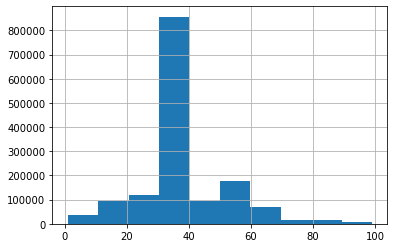

In [11]:
# Check range of hours for persons with ESR 1 or 4: at work civilians or armed forces
print(persons[(persons['ESR'] == 1) | (persons['ESR'] == 4)]['WKHP'].describe().compute())
pd.Series(persons[(persons['ESR'] == 1) | (persons['ESR'] == 4)]['WKHP']).hist()

In [12]:
persons[((persons['ESR'] == 1) | (persons['ESR'] == 4)) & (persons['WKHP']>50)]['WKHP'].describe().compute()

count    142221.000000
mean         64.307078
std          10.723942
min          51.000000
25%          60.000000
50%          65.000000
75%          80.000000
max          99.000000
Name: WKHP, dtype: float64

count    33091.000000
mean        36.010275
std         14.915749
min          1.000000
25%         35.000000
50%         40.000000
75%         40.000000
max         99.000000
Name: WKHP, dtype: float64


<AxesSubplot:>

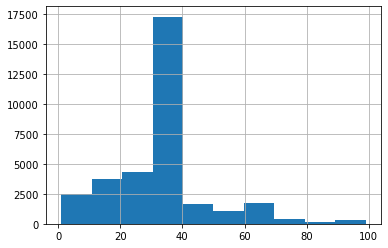

In [13]:
# Check range of hours for persons with ESR not 1 or 4: not at work civilians or armed forces, but with a job
print(persons[(persons['ESR'] == 2) | (persons['ESR'] == 5)]['WKHP'].describe().compute())
pd.Series(persons[(persons['ESR'] == 2) | (persons['ESR'] == 5)]['WKHP']).hist()

In [14]:
persons[((persons['ESR'] == 0))]['WKHP'].describe().compute()
# pd.persons[(((persons['ESR'] == 6 | (persons['ESR']==0))) & (persons['WKHP']>50)]['WKHP'].hist()

count    654911.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: WKHP, dtype: float64

In [15]:
# 100k records more than 40 hours per week for 3 and 6 ESR

# 8.5 ESR 4 or 5 have MIL of 1 or 3
Check if armed forces ESR 4 or 5 have an active duty status MIL of 1 or 3

In [16]:
# MIL codes for persons with ESR 4 or 5: armed forces
# MIL codes 1 and 3 code for those on active duty
persons[(persons['ESR'] == 4) | (persons['ESR'] == 5)]['MIL'].unique().compute()

0    1.0
1    3.0
Name: MIL, dtype: float64

# 8.6 Is there a pattern in COW values for those with MIL code != b or 4
For those in or used to be on active duty, what are COW values?

Mostly falls under COW 5, Federal government employee. Removing those that are on active duty brings the distribution closer to those that never served, but a large majority still work under the federal government. Similar findings to version 1 and 2.

0    1.0
1    0.0
2    5.0
3    2.0
4    6.0
5    3.0
6    4.0
7    7.0
8    9.0
9    8.0
Name: COW, dtype: float64


<AxesSubplot:>

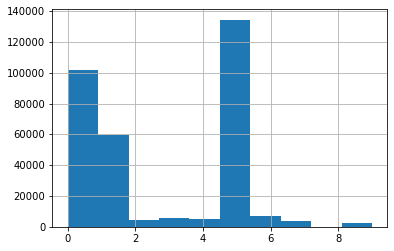

In [17]:
# Distribution of COW values for those in or used to be on active duty
print(persons[~((persons['MIL']==0) | (persons['MIL'] == 4))]['COW'].unique().compute())
pd.Series(persons[~((persons['MIL']==0) | (persons['MIL'] == 4))]['COW']).hist()

<AxesSubplot:>

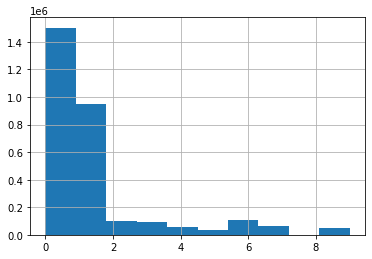

In [18]:
# Distribution of COW values for those that has never served
pd.Series(persons[(persons['MIL']==0) | (persons['MIL'] == 4)]['COW']).hist()

# 8.7  MIL b and ESR b have age < 17 
Check if MIL value less than 17 y/o and ESR value less than 16 (both values of 0) have all AGEP less than 17.

In [19]:
# Number of persons with ESR value less than 16 y/o, but AGEP greater than or equal to 17
persons[(persons['ESR'] == 0) & (persons['AGEP'] >= 17)].shape[0].compute()

0

In [20]:
# Number of persons with MIL value less than 16 y/o, but AGEP greater than or equal to 17
persons[(persons['MIL'] == 0) & (persons['AGEP'] >= 17)].shape[0].compute()

0

# 8.8 MIL 1 have ESR = 4 or 5
Check if MIL on active duty has ESR value for armed forces

In [21]:
persons[persons['MIL'] == 1]['ESR'].unique().compute()

0    4.0
1    5.0
Name: ESR, dtype: float64

# 8.9 ESR 4 or 5 have age <= 60

In [22]:
persons[((persons['ESR'] == 4) | (persons['ESR'] == 5)) & (persons['AGEP'] > 60)].shape[0].compute()

0

# 8.X Pattern in COWs with MIL 1 has ESR 4 or 5.

In [23]:
persons[persons['MIL'] == 1]['COW'].unique().compute()

0    5.0
Name: COW, dtype: float64

# 8.11 MIL = 1 or 3 have age > 60

Check for all persons with `MIL` codes `1` or `3` (active duty) and over `AGEP` 60.

All persons that are on active duty and over `AGEP` 60 are on active duty for training in Reserves/National Guard (`MIL` code `3`).

12951


<AxesSubplot:>

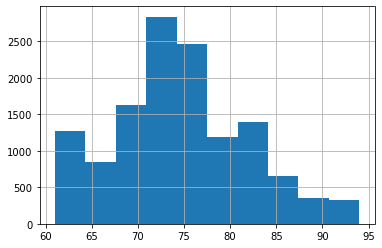

In [24]:
# Number and distribution of persons with MIL code 1 or 3 and are over AGEP 60
print(persons[((persons['MIL'] == 1) | (persons['MIL'] == 3)) & (persons['AGEP'] > 60)].shape[0].compute())
pd.Series(persons[((persons['MIL'] == 1) | (persons['MIL'] == 3)) & (persons['AGEP'] > 60)]['AGEP']).hist()

0


<AxesSubplot:>

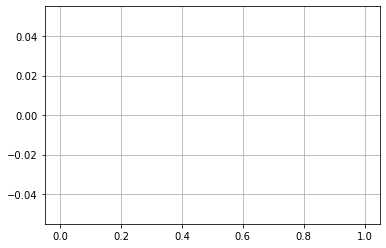

In [25]:
# Number and distribution of persons with MIL code 1 and are over AGEP 60
print(persons[(persons['MIL'] == 1) & (persons['AGEP'] > 60)].shape[0].compute())
pd.Series(persons[(persons['MIL'] == 1) & (persons['AGEP'] > 60)]['AGEP']).hist()

12951


<AxesSubplot:>

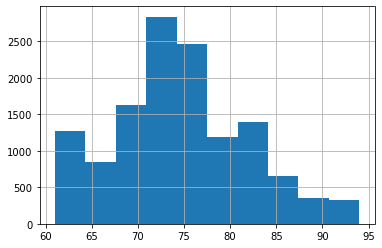

In [26]:
# Number and distribution of persons with MIL code 3 and are over AGEP 60
print(persons[(persons['MIL'] == 3) & (persons['AGEP'] > 60)].shape[0].compute())
pd.Series(persons[(persons['MIL'] == 3) & (persons['AGEP'] > 60)]['AGEP']).hist()

<AxesSubplot:>

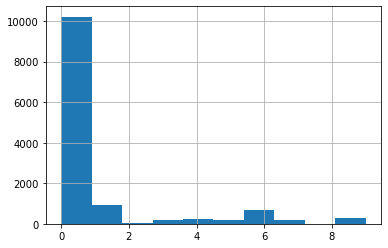

In [27]:
# Checks for COW code distributions for persons with MIL code 1 or 3
# Majority are COW code 0 (not in COW universe)
pd.Series(persons[((persons['MIL'] == 1) | (persons['MIL'] == 3)) & (persons['AGEP'] > 60)]['COW']).hist()

# Consistency checks between household income and vehicle ownership check   

# 7.a Household Income < 30K, more than 2 vehicles (currently looking at more than 4 vehicles)

# 7.b Household Income > 100K, 0 vehicles   

In [28]:
households_30k_2 = households[(households['HHADJINC'] < 30000) & (households['VEH'] > 4)]
households_30k_2.sort_values('VEH').compute()

,household_id,mgra,NP,HHADJINC,HHT,WIF,HUPAC,VEH,BLD,GQ_type
13754,13755,8184,6,16155.00,1.0,1.0,3.0,5.0,3.0,0.0
282235,912088,8735,6,0.00,5.0,NaN,4.0,5.0,2.0,0.0
282236,912089,8735,6,0.00,5.0,NaN,4.0,5.0,2.0,0.0
282237,912090,8735,6,0.00,5.0,NaN,4.0,5.0,2.0,0.0
282238,912091,8735,6,0.00,5.0,NaN,4.0,5.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
111852,741705,7147,1,10.77,4.0,NaN,4.0,6.0,1.0,0.0
115508,745361,7507,1,10.77,4.0,NaN,4.0,6.0,1.0,0.0
115509,745362,7507,1,10.77,4.0,NaN,4.0,6.0,1.0,0.0
88471,718324,486,1,10.77,4.0,NaN,4.0,6.0,1.0,0.0


In [29]:
pd.DataFrame(households_30k_2.sort_values('VEH').compute()).to_csv('households_30k_4.csv', index=False)

In [30]:
households['VEH'].mean().compute()

1.9753979415272407

<AxesSubplot:>

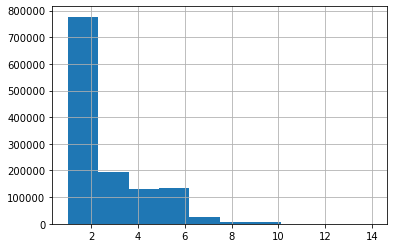

In [31]:
pd.Series(households['NP']).hist()

5.5588235294117645


<AxesSubplot:>

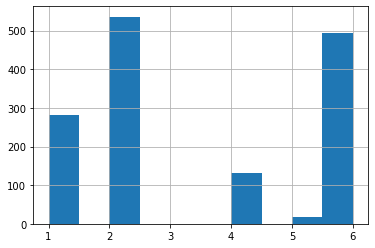

In [32]:
print(households_30k_2['VEH'].mean().compute())
pd.Series(households_30k_2['NP']).hist()

<AxesSubplot:>

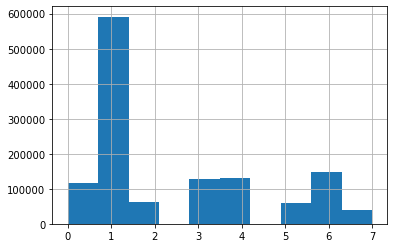

In [33]:
pd.Series(households['HHT']).hist()

<AxesSubplot:>

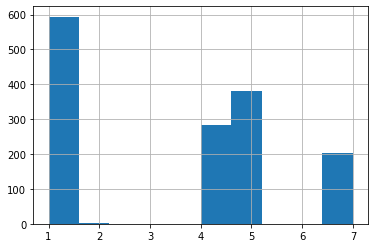

In [34]:
pd.Series(households_30k_2['HHT']).hist()

In [35]:
households_100k_0 = households[(households['HHADJINC'] >100000) & (households['VEH']==0)]
households_100k_0.compute()

,household_id,mgra,NP,HHADJINC,HHT,WIF,HUPAC,VEH,BLD,GQ_type
121,122,165,5,112008.0,1.0,2.0,3.0,0.0,2.0,0.0
379,380,565,2,134625.0,1.0,1.0,4.0,0.0,2.0,0.0
509,510,611,5,112008.0,1.0,2.0,3.0,0.0,2.0,0.0
810,811,1077,3,119547.0,3.0,3.0,4.0,0.0,2.0,0.0
3945,3946,3482,2,105976.8,1.0,2.0,4.0,0.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...
527487,1157340,9485,1,113623.5,6.0,NaN,4.0,0.0,9.0,0.0
528967,1158820,9566,3,123855.0,7.0,NaN,4.0,0.0,6.0,0.0
529824,1159677,10094,3,123855.0,7.0,NaN,4.0,0.0,6.0,0.0
529825,1159678,10094,3,123855.0,7.0,NaN,4.0,0.0,6.0,0.0


<AxesSubplot:>

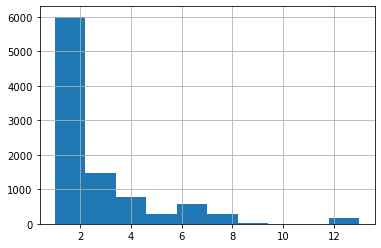

In [36]:
pd.Series(households_100k_0['NP']).hist()

In [37]:
pd.DataFrame(households_100k_0.compute()).to_csv('households_100k_0.csv', index=False)

In [38]:
households_100k_0[households_100k_0['NP']>10].drop(columns=['household_id', 'mgra']).drop_duplicates().compute()

,NP,HHADJINC,HHT,WIF,HUPAC,VEH,BLD,GQ_type
145354,13,260095.5,5.0,NaN,4.0,0.0,8.0,0.0


<AxesSubplot:>

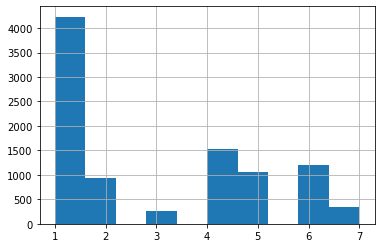

In [39]:
pd.Series(households_100k_0['HHT']).hist()